# Testing different features with RandomForest

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import bz2
import os
import sys
import nltk
import pickle
import pandas as pd
import scipy as sp
from IPython.display import display
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, explained_variance_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Caching stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

sys.path.append(os.path.abspath('../src'))
from fact_classification import *

2023-04-13 16:38:00.274985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the dataset.

In [3]:
df, df_crowdsourced, df_ground_truth = data_loading(local=True)
df = df.dropna().reset_index(drop=True)
df.head()

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict
0,16,I think we've seen a deterioration of values.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,8,16,0.000000,-1
1,17,I think for a while as a nation we condoned th...,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,16,17,-0.456018,-1
2,18,"For a while, as I recall, it even seems to me ...",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,29,18,-0.805547,-1
3,19,"So we've seen a deterioration in values, and o...",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,35,19,0.698942,-1
4,20,"We got away, we got into this feeling that val...",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,15,20,0.000000,-1


Load the baseline model scoring results. We will use this to compare against our new models.

In [4]:
# Load scoring results dataframe from the baseline model
df_score_train, df_score_test = score_loading()
df_score_train = df_score_train.reset_index(drop=True).drop(1)
df_score_test = df_score_test.reset_index(drop=True).drop(1)
print('Baseline model training scores:')
display(df_score_train)
print('Baseline model testing scores:')
display(df_score_test)

Baseline model training scores:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.0,0.998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999,1.0,1.0


Baseline model testing scores:


,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.6,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598


Load the features matrix that we generated in the `feature_generation.ipynb` notebook. This is a large sparse matrix so ww convert it to Compressed Sparse Row (CSR) format to avoid running out of memory when fitting our models.

In [5]:
with bz2.open('../results/df_features.bz2') as f:
    df_features = pickle.load(f)

df_features.head()

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,E_money,E_norp,E_ordinal,E_org,E_percent,E_person,E_product,E_quantity,E_time,E_work_of_art
0,0.000000,-0.776708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.456018,-0.147669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.805547,0.874519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.698942,1.346298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.226299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have 28229 features in total. However, we will not use all features at the same time, since many of them will be redundant. We will start by testing each of the pure feature sets on their own, then see if we can improve the score by combining two or more feature sets.

In [6]:
csr_features = sp.sparse.csr_matrix(df_features)

## Splitting data and generating indexes

We split the dataset according to the instructions in the assignment, where data up until and including year 2008 will be used for training, and data after 2008 will be used for testing. Here we also generate indexes for the various feature sets.

In [7]:
df_train, df_test, idx_train = test_train_split(df)

csr_features_train = csr_features[idx_train]
csr_features_test = csr_features[~idx_train]

# Column index for the numeric columns Sentiment and Length
col_idx_n = (df_features.columns == 'Sentiment') | (df_features.columns == 'Length')

# Column index for TF-IDF features on the raw Text column with n-grams=1
col_idx_w1 = df_features.columns.str.startswith('W1_')

# Column index for TF-IDF features on the raw Text column with n-grams=2
col_idx_w2 = df_features.columns.str.startswith('W2_')

# Column index for TF-IDF features on the stemmed text with n-grams=1
col_idx_ws = df_features.columns.str.startswith('WS_')

# Column index for POS features
col_idx_p = df_features.columns.str.startswith('P_')

# Column index for NER labels
col_idx_e = df_features.columns.str.startswith('E_')

### Setup model for GridSearchCV

We use GridSearchCV from scikit-learn to get the best combination of parameters for the model. Since we have an unbalanced dataset we set `class_weight='balanced_subsample'` for the RandomForestClassifier. This will ensure that we have a balanced distribution in the subtrees.

For the grid search we will test with 100, 500, and 1000 trees, and max depths of 5, 10, and 20. We limit the depth do avoid overfitting, and we limit the number of trees to reduce training time. Further, we use weighted f1-score for scoring the grid search, and we define a 4-fold cross validation.

In [8]:
rfc = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 20]
}

clf = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=4,
    n_jobs=10,
    return_train_score=True,
    verbose=1
)


## RandomForest

### Numeric (Length and Sentiment)

In [9]:
# Index for the two numeric columns Length and Sentiment
idx_n = col_idx_n

# Fit model
clf_n = clf.fit(csr_features_train[:, idx_n], df_train['Verdict'])


Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [10]:
# Print the best parameters found
clf_n.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [11]:
df_pred_train_n = clf_n.predict(csr_features_train[:, idx_n])
df_pred_test_n = clf_n.predict(csr_features_test[:, idx_n])

In [12]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_n, algorithm='RFC', features='N')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_n, algorithm='RFC', features='N')]
).reset_index(drop=True)

In [13]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.00,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.51,0.571


In [14]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470


Using only Sentiment and Length gets very low accuracy, even lower than our baseline model.

Save the trained model to disk.

In [15]:
with bz2.open('../models/rfc_n.bz2', 'wb') as f:
    pickle.dump(clf_n, f)

### TF-IDF, raw text, n-grams=1:

In [16]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_w1 = col_idx_w1

# Fit model
clf_w1 = clf.fit(csr_features_train[:, idx_w1], df_train['Verdict'])


Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [17]:
# Print the best parameters found
clf_w1.best_params_

{'max_depth': 20, 'n_estimators': 1000}

In [18]:
df_pred_train_w1 = clf_w1.predict(csr_features_train[:, idx_w1])
df_pred_test_w1 = clf_w1.predict(csr_features_test[:, idx_w1])

In [19]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_w1, algorithm='RFC', features='W1')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_w1, algorithm='RFC', features='W1')]
).reset_index(drop=True)

In [20]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.510,0.571
2,RFC,W1,0.934,0.521,0.770,0.854,0.836,0.869,0.776,0.826,0.882,0.651,0.773,0.834


In [21]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470
2,RFC,W1,0.788,0.298,0.654,0.695,0.813,0.467,0.444,0.674,0.800,0.364,0.529,0.677


In [22]:
# Save trained classifier to disk
with bz2.open('../models/rfc_w1.bz2', 'wb') as f:
    pickle.dump(clf_w1, f)

### TF-IDF, raw text, n-grams=2:

In [23]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_w2 = col_idx_w2

# Fit model
clf_w2 = clf.fit(csr_features_train[:, idx_w2], df_train['Verdict'])


Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [24]:
# Print the best parameters found
clf_w2.best_params_

{'max_depth': 20, 'n_estimators': 1000}

In [25]:
df_pred_train_w2 = clf_w2.predict(csr_features_train[:, idx_w2])
df_pred_test_w2 = clf_w2.predict(csr_features_test[:, idx_w2])

In [26]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_w2, algorithm='RFC', features='W2')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_w2, algorithm='RFC', features='W2')]
).reset_index(drop=True)

In [27]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.510,0.571
2,RFC,W1,0.934,0.521,0.770,0.854,0.836,0.869,0.776,0.826,0.882,0.651,0.773,0.834
3,RFC,W2,0.926,0.243,0.590,0.779,0.539,0.859,0.644,0.596,0.681,0.379,0.616,0.636


In [28]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470
2,RFC,W1,0.788,0.298,0.654,0.695,0.813,0.467,0.444,0.674,0.800,0.364,0.529,0.677
3,RFC,W2,0.789,0.173,0.495,0.639,0.494,0.631,0.351,0.472,0.607,0.271,0.411,0.516


In [29]:
# Save trained classifier to disk
with bz2.open('../models/rfc_w2.bz2', 'wb') as f:
    pickle.dump(clf_w2, f)

### TF-IDF, stemmed text, n-grams=1:

In [30]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_ws = col_idx_ws

# Fit model
clf_ws = clf.fit(csr_features_train[:, idx_ws], df_train['Verdict'])


Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [31]:
# Print the best parameters found
clf_ws.best_params_

{'max_depth': 20, 'n_estimators': 1000}

In [32]:
df_pred_train_ws = clf_ws.predict(csr_features_train[:, idx_ws])
df_pred_test_ws = clf_ws.predict(csr_features_test[:, idx_ws])

In [33]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_ws, algorithm='RFC', features='WS')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_ws, algorithm='RFC', features='WS')]
).reset_index(drop=True)

In [34]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.510,0.571
2,RFC,W1,0.934,0.521,0.770,0.854,0.836,0.869,0.776,0.826,0.882,0.651,0.773,0.834
3,RFC,W2,0.926,0.243,0.590,0.779,0.539,0.859,0.644,0.596,0.681,0.379,0.616,0.636
4,RFC,WS,0.911,0.401,0.738,0.819,0.793,0.831,0.667,0.767,0.848,0.541,0.701,0.782


In [35]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470
2,RFC,W1,0.788,0.298,0.654,0.695,0.813,0.467,0.444,0.674,0.800,0.364,0.529,0.677
3,RFC,W2,0.789,0.173,0.495,0.639,0.494,0.631,0.351,0.472,0.607,0.271,0.411,0.516
4,RFC,WS,0.781,0.280,0.608,0.677,0.743,0.555,0.417,0.634,0.761,0.372,0.495,0.645


In [36]:
# Save trained classifier to disk
with bz2.open('../models/rfc_ws.bz2', 'wb') as f:
    pickle.dump(clf_ws, f)

### POS tags:

In [37]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_p = col_idx_p

# Fit model
clf_p = clf.fit(csr_features[:, idx_p], df['Verdict'])

Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [38]:
clf_p.best_params_

{'max_depth': 20, 'n_estimators': 1000}

In [39]:
df_pred_train_p = clf_p.predict(csr_features_train[:, idx_p])
df_pred_test_p = clf_p.predict(csr_features_test[:, idx_p])

In [40]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_p, algorithm='RFC', features='P')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_p, algorithm='RFC', features='P')]
).reset_index(drop=True)

In [41]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.510,0.571
2,RFC,W1,0.934,0.521,0.770,0.854,0.836,0.869,0.776,0.826,0.882,0.651,0.773,0.834
3,RFC,W2,0.926,0.243,0.590,0.779,0.539,0.859,0.644,0.596,0.681,0.379,0.616,0.636
4,RFC,WS,0.911,0.401,0.738,0.819,0.793,0.831,0.667,0.767,0.848,0.541,0.701,0.782
5,RFC,P,0.994,0.889,0.991,0.982,0.983,0.983,0.976,0.981,0.988,0.934,0.984,0.982


In [42]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470
2,RFC,W1,0.788,0.298,0.654,0.695,0.813,0.467,0.444,0.674,0.800,0.364,0.529,0.677
3,RFC,W2,0.789,0.173,0.495,0.639,0.494,0.631,0.351,0.472,0.607,0.271,0.411,0.516
4,RFC,WS,0.781,0.280,0.608,0.677,0.743,0.555,0.417,0.634,0.761,0.372,0.495,0.645
5,RFC,P,0.990,0.890,0.994,0.980,0.984,0.987,0.961,0.978,0.987,0.936,0.978,0.979


In [43]:
# Save trained classifier to disk
with bz2.open('../models/rfc_p.bz2', 'wb') as f:
    pickle.dump(clf_p, f)

### NER labels:

In [44]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_e = col_idx_e

# Fit model
clf_e = clf.fit(csr_features[:, idx_e], df['Verdict'])

Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [45]:
clf_e.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [46]:
df_pred_train_e = clf_e.predict(csr_features_train[:, idx_e])
df_pred_test_e = clf_e.predict(csr_features_test[:, idx_e])

In [47]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_e, algorithm='RFC', features='E')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_e, algorithm='RFC', features='E')]
).reset_index(drop=True)

In [48]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.510,0.571
2,RFC,W1,0.934,0.521,0.770,0.854,0.836,0.869,0.776,0.826,0.882,0.651,0.773,0.834
3,RFC,W2,0.926,0.243,0.590,0.779,0.539,0.859,0.644,0.596,0.681,0.379,0.616,0.636
4,RFC,WS,0.911,0.401,0.738,0.819,0.793,0.831,0.667,0.767,0.848,0.541,0.701,0.782
5,RFC,P,0.994,0.889,0.991,0.982,0.983,0.983,0.976,0.981,0.988,0.934,0.984,0.982
6,RFC,E,0.806,0.195,0.599,0.696,0.757,0.372,0.466,0.650,0.780,0.256,0.524,0.668


In [49]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470
2,RFC,W1,0.788,0.298,0.654,0.695,0.813,0.467,0.444,0.674,0.800,0.364,0.529,0.677
3,RFC,W2,0.789,0.173,0.495,0.639,0.494,0.631,0.351,0.472,0.607,0.271,0.411,0.516
4,RFC,WS,0.781,0.280,0.608,0.677,0.743,0.555,0.417,0.634,0.761,0.372,0.495,0.645
5,RFC,P,0.990,0.890,0.994,0.980,0.984,0.987,0.961,0.978,0.987,0.936,0.978,0.979
6,RFC,E,0.741,0.226,0.644,0.656,0.791,0.334,0.410,0.637,0.765,0.270,0.501,0.637


In [50]:
# Save trained classifier to disk
with bz2.open('../models/rfc_e.bz2', 'wb') as f:
    pickle.dump(clf_e, f)

Out of the pure feature sets we see that the POS-tags gives the best results. We will now combine the POS-tags with other feature sets to see if we can improve the score.

### POS tags and Numerical features:

In [51]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_pn = col_idx_p | col_idx_n

# Fit model
clf_pn = clf.fit(csr_features[:, idx_pn], df['Verdict'])

Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [52]:
clf_pn.best_params_

{'max_depth': 20, 'n_estimators': 1000}

In [53]:
df_pred_train_pn = clf_pn.predict(csr_features_train[:, idx_pn])
df_pred_test_pn = clf_pn.predict(csr_features_test[:, idx_pn])

In [54]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_pn, algorithm='RFC', features='P_N')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_pn, algorithm='RFC', features='P_N')]
).reset_index(drop=True)

In [55]:
df_score_train

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,1.000,0.998,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.999,1.000,1.000
1,RFC,N,0.862,0.225,0.422,0.695,0.496,0.578,0.646,0.539,0.629,0.324,0.510,0.571
2,RFC,W1,0.934,0.521,0.770,0.854,0.836,0.869,0.776,0.826,0.882,0.651,0.773,0.834
3,RFC,W2,0.926,0.243,0.590,0.779,0.539,0.859,0.644,0.596,0.681,0.379,0.616,0.636
4,RFC,WS,0.911,0.401,0.738,0.819,0.793,0.831,0.667,0.767,0.848,0.541,0.701,0.782
5,RFC,P,0.994,0.889,0.991,0.982,0.983,0.983,0.976,0.981,0.988,0.934,0.984,0.982
6,RFC,E,0.806,0.195,0.599,0.696,0.757,0.372,0.466,0.650,0.780,0.256,0.524,0.668
7,RFC,P_N,0.999,0.935,0.998,0.992,0.992,0.999,0.989,0.992,0.995,0.966,0.993,0.992


In [56]:
df_score_test

,algorithm,features,p_NFS,p_UFS,p_CFS,p_wavg,r_NFS,r_UFS,r_CFS,r_wavg,f_NFS,f_UFS,f_CFS,f_wavg
0,RFC-baseline,W1,0.667,0.600,0.813,0.698,0.987,0.058,0.226,0.677,0.796,0.105,0.353,0.598
1,RFC,N,0.689,0.146,0.395,0.548,0.461,0.411,0.384,0.435,0.552,0.215,0.389,0.470
2,RFC,W1,0.788,0.298,0.654,0.695,0.813,0.467,0.444,0.674,0.800,0.364,0.529,0.677
3,RFC,W2,0.789,0.173,0.495,0.639,0.494,0.631,0.351,0.472,0.607,0.271,0.411,0.516
4,RFC,WS,0.781,0.280,0.608,0.677,0.743,0.555,0.417,0.634,0.761,0.372,0.495,0.645
5,RFC,P,0.990,0.890,0.994,0.980,0.984,0.987,0.961,0.978,0.987,0.936,0.978,0.979
6,RFC,E,0.741,0.226,0.644,0.656,0.791,0.334,0.410,0.637,0.765,0.270,0.501,0.637
7,RFC,P_N,0.996,0.927,0.999,0.989,0.990,0.998,0.979,0.988,0.993,0.961,0.989,0.988


Adding the two numerical features, "Length" and "Sentiment", seems to give a posibive effect on the scoring of the model.


In [57]:
# Save trained classifier to disk
with bz2.open('../models/rfc_pn.bz2', 'wb') as f:
    pickle.dump(clf_pn, f)

## Feature Importance

In [147]:
# Average feature importance
df_feature_importance = pd.DataFrame(clf_pn.best_estimator_.feature_importances_, index=df_features.columns[idx_pn], columns=['Importance']).sort_values('Importance', ascending=False)

In [125]:
# All feature importance for all trees
df_feature_all = pd.DataFrame([tree.feature_importances_ for tree in clf_pn.best_estimator_.estimators_], columns=df_features.columns[idx_pn])
df_feature_all.head()

,Sentiment,Length,P_CC,P_CD,P_DT,P_EX,P_FW,P_IN,P_JJ,P_JJR,...,P_UH,P_VB,P_VBD,P_VBG,P_VBN,P_VBP,P_VBZ,P_WDT,P_WP,P_WRB
0,0.067644,0.066721,0.032519,0.014063,0.050937,0.006133,0.000000,0.054443,0.040437,0.010805,...,0.000566,0.053242,0.069338,0.025549,0.025275,0.050352,0.029985,0.010291,0.012478,0.009479
1,0.063341,0.056805,0.041612,0.022257,0.049743,0.006784,0.000138,0.048862,0.033595,0.006845,...,0.000301,0.074085,0.067843,0.024162,0.027866,0.056928,0.024719,0.009844,0.016480,0.010643
2,0.063658,0.053080,0.034860,0.023875,0.052031,0.006844,0.000120,0.040062,0.035325,0.007317,...,0.000782,0.054197,0.104238,0.025308,0.044255,0.042437,0.028742,0.010940,0.013318,0.011444
3,0.063460,0.048046,0.039435,0.022290,0.053062,0.007068,0.000565,0.055346,0.031483,0.011242,...,0.000771,0.047994,0.110752,0.023620,0.037245,0.042218,0.025167,0.007247,0.011225,0.011253
4,0.066498,0.046781,0.036494,0.025183,0.052402,0.009244,0.000000,0.049889,0.036493,0.006601,...,0.000194,0.054058,0.092273,0.024253,0.034370,0.042246,0.031716,0.012794,0.012126,0.011224


In [148]:
# Melt data / long format
df_feature_long = pd.melt(df_feature_all, var_name='Feature', value_name='Value')

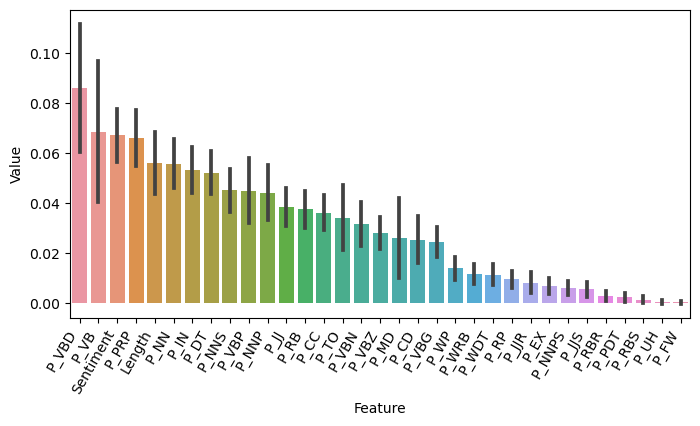

In [142]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(df_feature_long, x='Feature', y='Value', order=df_feature_importance.index, errorbar=('sd', 2), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
plt.show()

### POS tags and NER labels:

In [ ]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_pe = col_idx_p | col_idx_e

# Fit model
clf_pe = clf.fit(csr_features[:, idx_pe], df['Verdict'])

In [ ]:
clf_pe.best_params_

In [ ]:
df_pred_train_pe = clf_pe.predict(csr_features_train[:, idx_pe])
df_pred_test_pe = clf_pe.predict(csr_features_test[:, idx_pe])

In [ ]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_pe, algorithm='RFC', features='P_E')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_pe, algorithm='RFC', features='P_E')]
).reset_index(drop=True)

In [ ]:
df_score_train

In [ ]:
df_score_test

In [ ]:
# Save trained classifier to disk
with bz2.open('../models/rfc_pe.bz2', 'wb') as f:
    pickle.dump(clf_pe, f)

### POS tags and TF-IDF features:

Out of the word embeddings we got the best score using the TF-IDF method on the unstemmed text, so we try to combine this feature set with POS tags and see if the score improves.

In [ ]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_pw1 = col_idx_w1 | col_idx_e

# Fit model
clf_pw1 = clf.fit(csr_features[:, idx_pw1], df['Verdict'])

In [ ]:
clf_pw1.best_params_

In [ ]:
df_pred_train_pw1 = clf_pw1.predict(csr_features_train[:, idx_pw1])
df_pred_test_pw1 = clf_pw1.predict(csr_features_test[:, idx_pw1])

In [ ]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_pw1, algorithm='RFC', features='P_W1')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_pw1, algorithm='RFC', features='P_W1')]
).reset_index(drop=True)

In [ ]:
df_score_train

In [ ]:
df_score_test

We see that the score gets worse when combined with the TF-IDF features, so we will discard this feature combination.

In [ ]:
# Save trained classifier to disk
with bz2.open('../models/rfc_pw1.bz2', 'wb') as f:
    pickle.dump(clf_pw1, f)

### POS, NER, and Numeric features:

Out of the word embeddings we got the best score using the TF-IDF method on the unstemmed text, so we try to combine this feature set with POS tags and see if the score improves.

In [ ]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_pen = col_idx_p | col_idx_e | col_idx_n

# Fit model
clf_pen = clf.fit(csr_features[:, idx_pen], df['Verdict'])

In [ ]:
clf_pen.best_params_

In [ ]:
df_pred_train_pen = clf_pen.predict(csr_features_train[:, idx_pen])
df_pred_test_pen = clf_pen.predict(csr_features_test[:, idx_pen])

In [ ]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_pen, algorithm='RFC', features='P_E_N')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_pen, algorithm='RFC', features='P_E_N')]
).reset_index(drop=True)

In [ ]:
df_score_train

In [ ]:
df_score_test

In [ ]:
# Save trained classifier to disk
with bz2.open('../models/rfc_pen.bz2', 'wb') as f:
    pickle.dump(clf_pen, f)

### Improve model
Now, we will try to improve the model even more by tuning parameters. We already performed a GridSearchCV optimisation, but we see that the best fitted model maxed out both the n_features and max_depth parameters. Although we have a risk of overfitting, we will try to get an improvement.

In [ ]:
rfc_imp = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

param_grid_imp = {
    'n_estimators': [1000, 1500, 2000],
    'max_depth': [20, 25, 30]
}

clf_imp = GridSearchCV(
    estimator=rfc_imp,
    param_grid=param_grid_imp,
    scoring='f1_weighted',
    cv=4,
    n_jobs=10,
    return_train_score=True,
    verbose=1
)


In [ ]:
# Index for numeric (Length and Sentiment) and TF-IDF from stemmed text
idx_pn = col_idx_p | col_idx_n

# Fit model
clf_pn_imp = clf_imp.fit(csr_features[:, idx_pn], df['Verdict'])

In [ ]:
clf_pn_imp.best_params_

In [ ]:
df_pred_train_pn_imp = clf_pn_imp.predict(csr_features_train[:, idx_pn])
df_pred_test_pn_imp = clf_pn_imp.predict(csr_features_test[:, idx_pn])

In [ ]:
df_score_train = pd.concat([
    df_score_train,
    score_it(df_train['Verdict'], df_pred_train_pn_imp, algorithm='RFC', features='P_N_opt')]
).reset_index(drop=True)

df_score_test = pd.concat([
    df_score_test,
    score_it(df_test['Verdict'], df_pred_test_pn_imp, algorithm='RFC', features='P_N_opt')]
).reset_index(drop=True)

In [ ]:
df_score_train

In [ ]:
df_score_test

In [ ]:
# Save trained classifier to disk
with bz2.open('../models/rfc_pn_opt.bz2', 'wb') as f:
    pickle.dump(clf_pn_imp, f)

### Save metrix table

In [ ]:
# Save the scoring metrics to file
score_saving(df_score_train, df_score_test, fname='rfc_score')

### Export results dataframe to Latex for including in report.

In [ ]:
to_latex(df_score_train)

In [ ]:
to_latex(df_score_test)